# Moving from BayesFlow v1.1 to v2.0

_Authors: Leona Odole, Valentin Pratz_

**Note: This document is work in progress, and not all relevant changes are discussed yet. If you encounter problems during the transition, please do not hesitate to reach out.**

Long-time users of BayesFlow will notice that with the update to version 2.0 many things have changed. This short guide aims to clarify some of those changes. Users familiar with the previous Quickstart guide will notice that this notebook follows a similar structure, but assumes that users are already familiar with BayesFlow. We omit many of the the mathematical explanations in favor of demonstrating the differences in workflow. For a more detailed explanation of the BayesFlow framework, users should read, for example, the Starter Notebook on Bayesian Linear Regression.

Additionally to avoid confusion, similarly named objects from _BayesFlow v1.1_ will have `1.1` after their name, whereas those from _BayesFlow v2.0_ will not. Finally, a short table with a summary of the function call changes is provided at the end of the guide. 

## Keras Framework

BayesFlow 2.0 looks quite different from BayesFlow 1.1 because the library was refactored to replace the old backend, TensorFlow, with the new [Keras](https://keras.io) API. Users can now choose their preferred backend among the machine learning frameworks `TensorFlow`, `JAX` and `PyTorch`.

In [ ]:
import numpy as np

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import bayesflow as bf
import pandas as pd

In general, BayesFlow 2.0 relies much more on dictionaries since parameters are now named by convention. Many objects now expect a dictionary, and parameters and data are returned as dictionaries as well. 

## Example Workflow 

### Priors and Likelihood Model

Any BayesFlow workflow begins with simulated data which is specified with a prior and a corresponding likelihood function (simulator). While these two core components are still present, their use and naming conventions within the workflow have changed. 

Previously users would define a prior function and pass it to a `Prior1.1` object to sample prior values. The likelihood would also be specified via a function and passed to a `Simulator1.1` wrapper to produce observations for given parameter values. These were then combined in the `GenerativeModel1.1`.  

In 2.0 we no longer make use of the `Prior1.1`, `Simulator1.1` or `GenerativeModel1.1` objects. Instead, the `Simulator` class comprises the whole functionality, taking the role of the `GenerativeModel1.1`. It directly produces joint samples from prior and likelihood, without creating separate `Prior1.1` and `Simulator1.1` objects first. The `bf.simulator.make_simulator` offers a convencient wrapper to create the appropriate simulator for different settings.

In [2]:
def theta_prior():
    theta = np.random.normal(size=4)
    # previously: 
    # return theta 
    return dict(theta=theta) # now we return a dictionary
    

def likelihood_model(theta, n_obs):
    x = np.random.normal(loc=theta, size=(n_obs, theta.shape[0]))
    return dict(x=x)

Previously the prior and likelihood were defined as

``` python
prior_1 = bf.simulation.Prior(prior_fun=theta_prior)
simulator_1 = bf.simulation.Simulator(simulator_fun=likelihood_model)
model_1 = bf.simulation.GenerativeModel(prior=prior_1, simulator=simulator_1)
```

Whereas the new framework directly uses the likelihood and prior functions directly in the simulator. In addition, we can define a meta function which allows us, for example, to dynamically set the number of observations per simulated batch. 

In [3]:
def meta():
    return dict(n_obs=1)

simulator = bf.make_simulator([theta_prior, likelihood_model], meta_fn=meta)

We can then generate batches of training samples as follows.

In [4]:
sim_draws = simulator.sample(500)
print(sim_draws["x"].shape)
print(sim_draws["theta"].shape)

(500, 1, 4)
(500, 4)


### Adapter and Data Configuration

In _BayesFlow 2.0_ we now need to specify the data configuration. To make this as easy as possible, we offer a (semi-)invertible processing pipeline, the `bf.adapters.Adapter` class. It can be used to perform operations like standardization, but also for renaming and grouping variables into the format required by BayesFlow.

In general, BayesFlow expects three different kinds of inputs. The `summary_variables` are variables that will be summarized by a summary network. The `inference_variables` are variables we want to learn the approximate distributions for. In the posterior approximation setting, we would provide the parameter values drawn from the prior distribution, as we want to approximate a conditional distribution $p(\theta|x)$ of the parameters $\theta$. The `inference_conditions` are variables which are directly passed as conditions, without going through a summary network. Examples for this are hand-crafted summary statistics, as well as context variables like the number of observations. Previously these things were inferred from the type of network used, but now they need to be defined explictly using the `adapter`. The new approach is much more explicit and extensible. It also makes it easier to change individual settings, while keeping other settings at their defaults.

The example below shows an example of an adapter. After some initial processing, including the standardization of the variables, it renames the respective variables to establish the required format.

In [5]:
adapter = (
    bf.adapters.Adapter()
    .to_array()
    .broadcast("n_obs", to="theta")
    .convert_dtype(from_dtype="float64", to_dtype="float32")
    .standardize(exclude=["n_obs"])
    .rename("x", "summary_variables")
    .rename("theta", "inference_variables")
    .rename("n_obs", "inference_conditions")
)

For a full list of the adapter transforms, please refer to the documentation. 

### Summary Network and Inference Network

As in _BayesFlow 1.1_, users can specify an appropriate summary and inference network. All networks can be found in the `bf.networks` module. Summary networks inherit from the `SummaryNetwork` class. Please note that not all summary networks have been ported to the new version yet, so please refer to the API reference to see if the networks you require are already available. If a network you need is missing, please consider opening an issue so that we can prioritize its implementation. Also, please be aware that the parameters and defaults for some classes have changed, so you might need to adapt your code.

In [6]:
summary_net = bf.networks.DeepSet(depth=2, summary_dim=10)

For the inference network there are now several implemented architectures for users to choose from. They are `FlowMatching`, `ConsistencyModel`, and `CouplingFlow`. For this demonstration we use `FlowMatching`, for explanations on the different models please refer to the other examples and the API documentation. 

In [7]:
inference_net = bf.networks.FlowMatching()

### Approximator (Amortizer)

Previously the actual training and amortization was done with two different objects, an `Amortizer1.1` and a `Trainer1.1`. First, users would create an amortizer containing the summary and inference networks.

``` python
# Renamed to Approximator
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

# Defunct
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=gen_model)
```

This functionality is now handled by the `bf.approximators` module. The default approximator is the `ContinuousApproximator`, which approximates distributions for continuous variables. It takes the summary network, inference network and the data adapter as arguments. The `PointApproximator` enables the approximation of point summaries .

In [8]:
approximator = bf.approximators.ContinuousApproximator(
    summary_network=summary_net,
    inference_network=inference_net,
    adapter=adapter
)

Whereas previously a  `Trainer1.1` object was used for training, users can now directly call fit on the `Approximator`. For additional flexibility in training, the `approximator` also has two additional arguments the `learning_rate` and `optimizer`. The optimizer can be any Keras optimizer.

In [9]:
learning_rate = 1e-4
optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=1.1)

Users must then compile the `approximator` with the `optimizer` to make everything ready for training.

In [10]:
approximator.compile(optimizer=optimizer)

To train the network users now only need to call fit on the `approximator`. 

In [ ]:
history = approximator.fit(
    epochs=50,
    num_batches=200,
    batch_size=64,
    simulator=simulator
)

## Diagnostics 

Another change was made in the model diagnostics. Much of the functionality remains the same, but the naming convention has changed. For example previously users would plot losses by using `bf.diagnostics.plot_losses()`. In *BayesFlow 2.0*, we instead have all the plotting function grouped together in `bf.diagnostics.plots`. This means, for example, that the loss function is now in `bf.diagnostics.plots.loss()`.

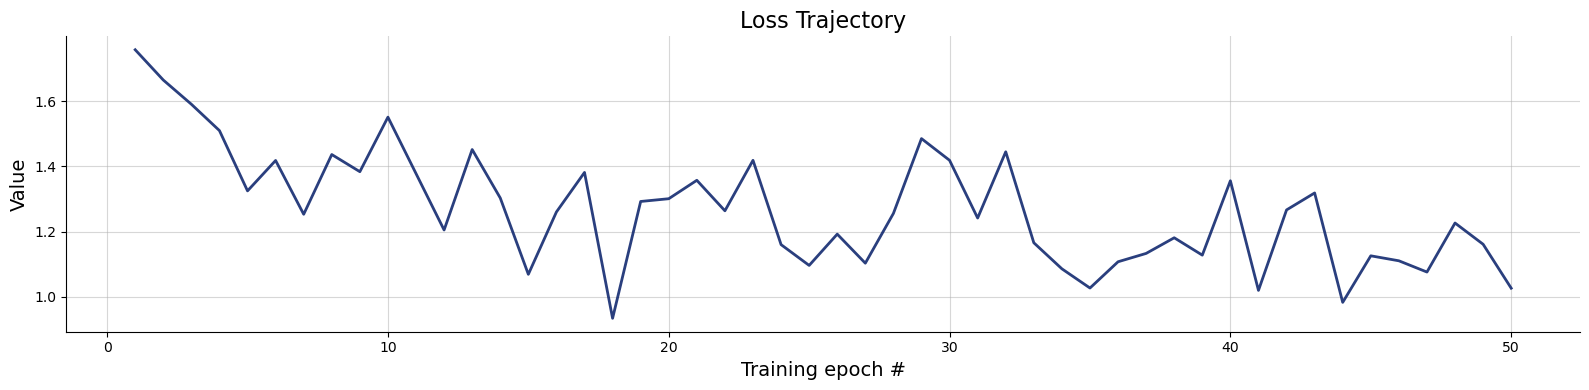

In [12]:
f = bf.diagnostics.plots.loss(
    history=history
)

This was done to also incorporate other diagnostic metrics such as calibration error, posterior contraction, and root mean squared error. These functions can be found in the `bf.diagnostics.metrics` submodule. For more information please refer to the API documentation.

## Summary Change Table 

| BayesFlow v1.1       | BayesFlow v2.0 usage |
| :--------| :---------| 
| `Prior`, `Simulator` | Defunct and no longer standalone objects but incorporated into `bf.simulators.Simulator` | 
|`GenerativeModel`     | Defunct with it's functionality having been taken over by `bf.simulators.make_simulator` | 
| `training.configurator` | Functionality taken over by `bf.adapters.Adapter` | 
|`Trainer` | Functionality taken over by `fit` method of `bf.approximators.Approximator` | 
| `AmortizedPosterior`, `AmortizedLikelihood` | Functionality taken over by `ContinuousApproximator` | 